# Lab 02: Feature Engineering & Evaluation

**Group 09:**

---

## 1. Introduction
In this notebook, we focus on **Feature Engineering**. We will design and compare three different feature representations of the MNIST digits to see how they affect the model's performance:
1.  **Baseline:** Normalized Raw Pixels (784 features).
2.  **Design 1:** Edge Detection (Sobel Filter) - Focuses on structural shape.
3.  **Design 2:** Dimensionality Reduction (Average Pooling) - Reduces noise and feature size.

We also implement custom evaluation metrics (Confusion Matrix, Precision, Recall, F1-Score) from scratch.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing (Sobel)
import os

np.random.seed(42)

def load_mnist_data(data_path='../data/raw/mnist.npz'):
    """Loads MNIST data from .npz file."""
    if not os.path.exists(data_path):
        print(f"Data file not found at {data_path}. Please run Notebook 1 first to download it.")
        return None, None, None, None

    with np.load(data_path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    # Pre-processing basic: Normalize to [0, 1]
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    return x_train, y_train, x_test, y_test

def one_hot_encode(y, num_classes=10):
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    for i in range(m):
        one_hot[i, y[i]] = 1
    return one_hot

# Load Data (Keep as images 28x28 initially for Feature Extraction)
X_train_img, y_train, X_test_img, y_test = load_mnist_data()
print(f"Data Loaded: {X_train_img.shape} (Images)")

Data Loaded: (60000, 28, 28) (Images)


In [42]:
class SoftmaxRegression:
    def __init__(self, n_features, n_classes, learning_rate=0.1, momentum=0.9, l2_reg=1e-4):
        """
        Softmax Regression with Momentum and L2 Regularization.
        This advanced implementation helps the model converge faster and generalize better.
        """
        self.n_features = n_features
        self.n_classes = n_classes
        self.lr = learning_rate
        self.momentum = momentum
        self.l2_reg = l2_reg
        self.losses = []
        
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros((1, n_classes))
        self.v_W = np.zeros_like(self.W)
        self.v_b = np.zeros_like(self.b)

    def softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        z = np.dot(X, self.W) + self.b
        return self.softmax(z)

    def fit(self, X, y, epochs=50, batch_size=256, verbose=False):
        m = X.shape[0]
        self.losses = []
        
        for epoch in range(epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, m, batch_size):
                end_idx = min(i + batch_size, m)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]
                
                # Forward
                y_pred = self.forward(X_batch)
                
                # Gradients (with L2 penalty on W)
                dz = y_pred - y_batch
                dw = (np.dot(X_batch.T, dz) / X_batch.shape[0]) + (self.l2_reg * self.W)
                db = np.sum(dz, axis=0, keepdims=True) / X_batch.shape[0]
                
                # Momentum Update
                self.v_W = self.momentum * self.v_W + self.lr * dw
                self.v_b = self.momentum * self.v_b + self.lr * db
                self.W -= self.v_W
                self.b -= self.v_b
                
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

## 2. Custom Evaluation Metrics

Since we cannot use `sklearn.metrics`, we implement the evaluation functions manually.
* **Confusion Matrix:** A table showing predicted vs. actual counts.
* **Precision:** $TP / (TP + FP)$
* **Recall:** $TP / (TP + FN)$
* **F1-Score:** Harmonic mean of Precision and Recall.

In [30]:
def compute_confusion_matrix(y_true, y_pred, n_classes=10):
    """
    Computes Confusion Matrix manually.
    Rows: Actual, Cols: Predicted
    """
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

def compute_metrics(y_true, y_pred, n_classes=10):
    """
    Computes Precision, Recall, and F1-score for each class and their macro-average.
    """
    cm = compute_confusion_matrix(y_true, y_pred, n_classes)
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for c in range(n_classes):
        tp = cm[c, c]
        fp = np.sum(cm[:, c]) - tp
        fn = np.sum(cm[c, :]) - tp
        
        # Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    metrics = {
        "confusion_matrix": cm,
        "precision_per_class": precisions,
        "recall_per_class": recalls,
        "f1_per_class": f1_scores,
        "macro_precision": np.mean(precisions),
        "macro_recall": np.mean(recalls),
        "macro_f1": np.mean(f1_scores),
        "accuracy": np.mean(y_true == y_pred)
    }
    return metrics

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Visualizes the confusion matrix."""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

## 3. Feature Extraction

### 3.1. Design 1: Flattened Raw Pixels (Baseline)
**Concept:**
This is the simplest approach. We take the $28 \times 28$ image matrix and flatten it into a single vector of $784$ elements.
* **Pros:** Retains all information.
* **Cons:** High dimensionality (784 features), sensitive to noise and small shifts/rotations.

**Transformation:** $(28, 28) \rightarrow (784,)$

In [31]:
def extract_raw_features(X_img):
    """
    Flattens 2D images into 1D vectors.
    Args:
        X_img: (N, 28, 28)
    Returns:
        (N, 784)
    """
    # Simply reshape
    return X_img.reshape(X_img.shape[0], -1)

# Apply to data
X_train_raw = extract_raw_features(X_train_img)
X_test_raw = extract_raw_features(X_test_img)

print(f"Feature 1 (Raw) Shape: {X_train_raw.shape}")

Feature 1 (Raw) Shape: (60000, 784)


### 3.2. Design 2: Edge Detection (Sobel) 
**Concept:**
Handwritten digits are defined by their shapes (strokes), not the background. We use the **Sobel Operator** to calculate the gradient of image intensity. This highlights edges (transitions from black to white) and suppresses constant background areas.

**Mechanism:**
1.  Apply Sobel Filter in X direction ($G_x$) and Y direction ($G_y$).
2.  Compute gradient magnitude: $G = \sqrt{G_x^2 + G_y^2}$.
3.  Flatten the resulting edge map.

**Expected Benefit:** The model focuses on the *structure* of the digit rather than pixel intensity, potentially making it more robust to lighting or ink thickness variations.

In [32]:
def extract_sobel_features(X_img):
    """
    Applies Sobel edge detection to each image.
    Args:
        X_img: (N, 28, 28)
    Returns:
        (N, 784) - Flattened edge maps
    """
    features = []
    for img in X_img:
        # Convert to roughly 0-255 range for OpenCV stability if needed, 
        # but cv2.Sobel works with float32 too.
        # Here we use float32 directly.
        
        # Gradient X
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        # Gradient Y
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        
        # Magnitude
        magnitude = np.sqrt(sobelx**2 + sobely**2)
        
        # Normalize to [0, 1] range per image
        magnitude = (magnitude - np.min(magnitude)) / (np.max(magnitude) + 1e-8)
        
        features.append(magnitude.flatten())
        
    return np.array(features)

# Apply to data (This might take a few seconds)
print("Extracting Sobel features...")
X_train_sobel = extract_sobel_features(X_train_img)
X_test_sobel = extract_sobel_features(X_test_img)
print(f"Feature 2 (Sobel) Shape: {X_train_sobel.shape}")

Extracting Sobel features...
Feature 2 (Sobel) Shape: (60000, 784)


### 3.3. Design 3: Dimensionality Reduction (Average Pooling) 

[Image of Max pooling and Average pooling operation]

**Concept:**
The original $784$ features might contain redundant information (neighboring pixels are often similar). We can reduce the dimensionality by performing **Average Pooling**.

**Mechanism:**
We divide the $28 \times 28$ image into $4 \times 4$ distinct blocks. For each block, we calculate the average value.
* Input: $28 \times 28$
* Pooling Kernel: $4 \times 4$
* Output: $7 \times 7 = 49$ features.

**Expected Benefit:**
* Drastically reduces model size (weights matrix is $16\times$ smaller).
* Faster training.
* Acts as a form of regularization (blurring detail to prevent overfitting).

In [33]:
def extract_pooling_features(X_img, pool_size=4):
    """
    Reduces dimensionality using Average Pooling.
    28x28 -> (28/4)x(28/4) = 7x7 -> 49 features.
    """
    N, H, W = X_img.shape
    new_H = H // pool_size
    new_W = W // pool_size
    
    # Reshape to (N, new_H, pool_size, new_W, pool_size)
    # This trick allows us to use numpy mean axis to pool
    reshaped = X_img.reshape(N, new_H, pool_size, new_W, pool_size)
    
    # Mean over axis 2 and 4 (the pooling dimensions)
    pooled = reshaped.mean(axis=(2, 4))
    
    # Flatten
    return pooled.reshape(N, -1)

# Apply to data
X_train_pool = extract_pooling_features(X_train_img, pool_size=4)
X_test_pool = extract_pooling_features(X_test_img, pool_size=4)

print(f"Feature 3 (Pooling) Shape: {X_train_pool.shape}")

Feature 3 (Pooling) Shape: (60000, 49)


### 3.4. Feature Design 4: Deskewing (Preprocessing)

**Concept:**
Handwritten digits are often written with a slant (italic style). Since Softmax Regression is a linear model, it performs pixel-to-pixel matching. A slanted '1' does not align well with a vertical '1', causing classification errors.
**Deskewing** is a preprocessing technique that "straightens" the digits before feature extraction.

**Mechanism:**
1.  Calculate the **Image Moments** to measure the skew (tilt) of the digit.
2.  Compute the skew angle.
3.  Apply an **Affine Transformation** (shifting pixels horizontally) to cancel out the skew.

**Pros & Cons:**
* **Pros:** Significantly reduces intra-class variance. Makes the model robust to different writing styles.
* **Cons:** Adds computational overhead during preprocessing.

In [39]:
def deskew_image(img):
    """
    Deskews (straightens) a digit image using image moments.
    
    Args: 
        img (numpy.ndarray): 28x28 grayscale image.
    Returns: 
        numpy.ndarray: 28x28 deskewed image.
    """
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        # Cannot deskew if variance is too small (e.g., empty image or simple dot)
        return img.copy()
    
    # Calculate skew based on central moments
    skew = m['mu11'] / m['mu02']
    
    # Create Affine Transformation Matrix to shift pixels
    # M = [1, skew, offset]
    M = np.float32([[1, skew, -0.5*28*skew], [0, 1, 0]])
    
    # Apply transformation (warp)
    # flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR
    img_deskewed = cv2.warpAffine(img, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img_deskewed

def extract_deskewed_features(X_img):
    """
    Applies deskewing to the entire dataset.
    
    Args:
        X_img: (N, 28, 28) image batch.
    Returns:
        (N, 784) flattened deskewed features.
    """
    print("Preprocessing: Deskewing images (This may take a while)...")
    features = []
    for img in X_img:
        # Convert to uint8 (0-255) for OpenCV if normalized
        if img.max() <= 1.0:
            img_uint8 = (img * 255).astype(np.uint8)
        else:
            img_uint8 = img.astype(np.uint8)
            
        deskewed = deskew_image(img_uint8)
        
        # Normalize back to [0, 1] and flatten
        features.append((deskewed.astype(np.float32) / 255.0).flatten())
        
    return np.array(features)

# Apply to data
X_train_deskew = extract_deskewed_features(X_train_img)
X_test_deskew = extract_deskewed_features(X_test_img)

print(f"Feature 4 (Deskewed) Shape: {X_train_deskew.shape}")

Preprocessing: Deskewing images (This may take a while)...
Preprocessing: Deskewing images (This may take a while)...
Feature 4 (Deskewed) Shape: (60000, 784)


### 3.5. Feature Design 5: Histogram of Oriented Gradients (HOG)


**Concept:**
HOG is a powerful feature descriptor used in Computer Vision (famous for pedestrian detection). Instead of using raw pixel values, it counts the occurrences of **gradient orientation** in localized portions of the image.

**Mechanism:**
1.  Divide the image into small connected regions called cells.
2.  For pixels within each cell, compile a histogram of gradient directions.
3.  Concatenate histograms to form the feature vector.

**Pros & Cons:**
* **Pros:** Focuses on the **shape and structure** of the digit rather than pixel intensity. Invariant to geometric and photometric transformations.
* **Cons:** High dimensionality if parameters are not carefully tuned.

In [40]:
def extract_hog_features(X_img):
    """
    Extracts HOG descriptors from images using OpenCV.
    
    Args:
        X_img: (N, 28, 28) image batch.
    Returns:
        (N, n_hog_features) feature matrix.
    """
    print("Extracting HOG features...")
    # Initialize HOG descriptor with parameters tuned for MNIST 28x28
    # Window Size: 28x28
    # Block Size: 14x14 (Normalization over blocks)
    # Block Stride: 7x7 (Overlap)
    # Cell Size: 14x14 (Histogram calculation area)
    # Bins: 9 (Number of gradient directions)
    hog = cv2.HOGDescriptor(
        _winSize=(28, 28),
        _blockSize=(14, 14),
        _blockStride=(7, 7),
        _cellSize=(14, 14),
        _nbins=9
    )
    
    features = []
    for img in X_img:
        # HOG expects uint8 image
        img_uint8 = (img * 255).astype(np.uint8)
        
        # Compute HOG
        h = hog.compute(img_uint8)
        features.append(h.flatten())
        
    return np.array(features)

# Apply to data
X_train_hog = extract_hog_features(X_train_img)
X_test_hog = extract_hog_features(X_test_img)

print(f"Feature 5 (HOG) Shape: {X_train_hog.shape}")

Extracting HOG features...
Extracting HOG features...
Feature 5 (HOG) Shape: (60000, 81)


### 3.6. Feature Design 6: Principal Component Analysis (PCA)


**Concept:**
PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (pixels) into a set of values of linearly uncorrelated variables called **Principal Components**.

**Mechanism:**
1.  **Center** the data (subtract mean).
2.  Compute the **Covariance Matrix**.
3.  Perform **Eigen Decomposition** (SVD) to find eigenvectors (principal components).
4.  Project the original 784-dimensional data onto the top $K$ eigenvectors (e.g., $K=80$).

**Pros & Cons:**
* **Pros:** Reduces dimensionality (faster training), removes noise (background variations), and retains the most important information (variance).
* **Cons:** Loss of interpretability (features are no longer pixels), potential information loss if $K$ is too small.

In [41]:
def train_pca(X, n_components=80):
    """
    Trains PCA on the dataset X using SVD (Singular Value Decomposition).
    
    Args:
        X: (N, 784) flattened data.
        n_components: Number of principal components to keep.
    Returns:
        components: (784, n_components) projection matrix.
        mean: (784,) mean vector of X.
    """
    print(f"Computing PCA (Target components: {n_components})...")
    
    # 1. Compute Mean and Center the data
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    
    # 2. Compute Covariance Matrix
    # C = (X^T X) / (m-1)
    # Using rowvar=False because rows are samples
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # 3. Compute Eigenvectors using SVD
    # U, S, Vt = svd(Cov)
    U, S, Vt = np.linalg.svd(cov_matrix)
    
    # 4. Select top K components (eigenvectors)
    components = U[:, :n_components]
    
    return components, mean

def apply_pca(X, components, mean):
    """
    Projects data X onto the PCA components.
    """
    X_centered = X - mean
    return np.dot(X_centered, components)

# IMPORTANT: PCA should be fit on TRAINING data only to avoid data leakage
pca_components, pca_mean = train_pca(X_train_raw, n_components=80)

# Apply transformation
X_train_pca = apply_pca(X_train_raw, pca_components, pca_mean)
X_test_pca = apply_pca(X_test_raw, pca_components, pca_mean)

print(f"Feature 6 (PCA) Shape: {X_train_pca.shape}")

Computing PCA (Target components: 80)...
Feature 6 (PCA) Shape: (60000, 80)


### 3.7. Visual Comparison of All Feature Vectors

**Purpose:**
Before training, we visually verify that our feature extraction algorithms are working correctly. This helps us understand what information the model actually "sees".

**What to observe:**
1.  **Raw Pixels:** The original image (often slanted/noisy).
2.  **Deskewed:** The same digit rotated upright. Notice how the geometry is standardized.
3.  **Sobel Edge:** Only the white outlines remain; internal ink density is removed.
4.  **HOG (Gradient Map):** Visualizes the edges and their intensity. HOG builds histograms based on this map.
5.  **PCA (Reconstructed):** The image is compressed to 80 numbers and then reconstructed. Notice it looks like a "smoother" or "ghostly" version of the original, filtering out some high-frequency noise.
6.  **Avg Pooling:** The image is pixelated (7x7). It retains the rough layout but loses all fine details.

**Instruction:**
> **Action:** Re-run the cell below multiple times (using `Ctrl + Enter`) to see the transformation effects on different random digits.

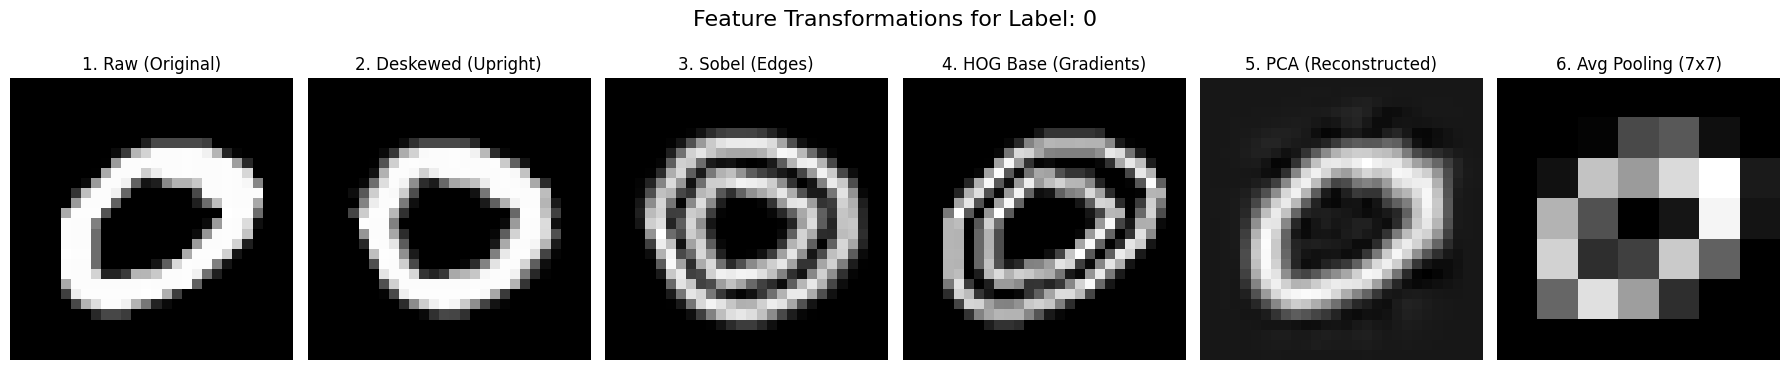

In [53]:
# Visualize features for a random digit
# Pick a random image
idx = np.random.randint(0, X_train_img.shape[0])
original_img = X_train_img[idx]
label = np.argmax(one_hot_encode(y_train)[idx])

# --- 1. Raw ---
feat_raw = original_img

# --- 2. Deskewed ---
# Convert to uint8 for processing
img_uint8 = (original_img * 255).astype(np.uint8) if original_img.max() <= 1.0 else original_img.astype(np.uint8)
feat_deskewed = deskew_image(img_uint8)

# --- 3. Sobel ---
# Calculate gradients
sobelx = cv2.Sobel(feat_deskewed, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(feat_deskewed, cv2.CV_64F, 0, 1, ksize=3)
feat_sobel = np.sqrt(sobelx**2 + sobely**2)

# --- 4. HOG Base (Gradient Magnitude) ---
# Simple visualization of gradients (what HOG is based on)
g_x = cv2.Sobel(img_uint8, cv2.CV_32F, 1, 0, ksize=1)
g_y = cv2.Sobel(img_uint8, cv2.CV_32F, 0, 1, ksize=1)
feat_hog_vis, _ = cv2.cartToPolar(g_x, g_y)

# --- 5. PCA Reconstruction ---
# Project to low dimension (80) then project back to 784 to see what's lost
# Feature vector = (X - mu) . U
# Reconstructed = Feature . U^T + mu
# Note: We use the pca_components/mean trained in section 3.6
input_vec = extract_raw_features(original_img.reshape(1, 28, 28)) # Flatten
pca_latent = np.dot(input_vec - pca_mean, pca_components)         # Compress
pca_reconstructed = np.dot(pca_latent, pca_components.T) + pca_mean # Decompress
feat_pca = pca_reconstructed.reshape(28, 28)

# --- 6. Pooling ---
feat_pool = extract_pooling_features(original_img.reshape(1, 28, 28), pool_size=4).reshape(7, 7)

# --- PLOTTING ---
plt.figure(figsize=(18, 4))
plt.suptitle(f"Feature Transformations for Label: {label}", fontsize=16)

plots = [
    ("1. Raw (Original)", feat_raw),
    ("2. Deskewed (Upright)", feat_deskewed),
    ("3. Sobel (Edges)", feat_sobel),
    ("4. HOG Base (Gradients)", feat_hog_vis),
    ("5. PCA (Reconstructed)", feat_pca),
    ("6. Avg Pooling (7x7)", feat_pool)
]

for i, (title, img) in enumerate(plots):
    plt.subplot(1, 6, i + 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Experiment 1: Overall Performance Comparison

### 4.1. Experimental Setup
We will evaluate the classification performance of Softmax Regression using the 6 different feature representations we have prepared.

* **Model:** Softmax Regression (Momentum=0.9, L2=1e-4, LR=0.1).
* **Training Configuration:** 50 Epochs, Batch Size 256.
* **Metric:** Accuracy and Macro F1-Score on the Test Set (10,000 samples).

### 4.2. Feature Candidates
1.  **Raw Pixels (Baseline):** 784 features.
2.  **Sobel Edge:** 784 features (Structure focused).
3.  **Average Pooling:** 49 features (7x7 grid) - Dimensionality Reduction.
4.  **Deskewed Pixels:** 784 features - Preprocessing (Geometry correction).
5.  **HOG Features:** 81 features (Standard OpenCV config) - Shape Descriptor.
6.  **PCA:** 80 components - Statistical Compression.

### 4.3. Hypothesis & Expectation
* **Baseline:** Expected ~92%.
* **Deskewed & HOG:** Expected to **outperform** the baseline significantly (reaching >96%) because they handle geometric variations (slant/shape) better than raw pixels.
* **PCA & Pooling:** Expected to maintain competitive accuracy (>90%) despite a massive reduction in feature size, proving the redundancy of MNIST data.

=============== RUNNING EXPERIMENT 1 ===============

Training on: 1. Raw Pixels (Dim: 784)...
--> Accuracy: 92.67%
--> F1-Score: 0.9256

Training on: 2. Sobel Edge (Dim: 784)...
--> Accuracy: 89.57%
--> F1-Score: 0.8944

Training on: 3. Avg Pooling (7x7) (Dim: 49)...
--> Accuracy: 88.59%
--> F1-Score: 0.8837

Training on: 4. Deskewed (Dim: 784)...
--> Accuracy: 94.70%
--> F1-Score: 0.9464

Training on: 5. HOG (Dim: 81)...
--> Accuracy: 96.38%
--> F1-Score: 0.9638

Training on: 6. PCA (80) (Dim: 80)...
--> Accuracy: 91.76%
--> F1-Score: 0.9162

=============== DONE ===============


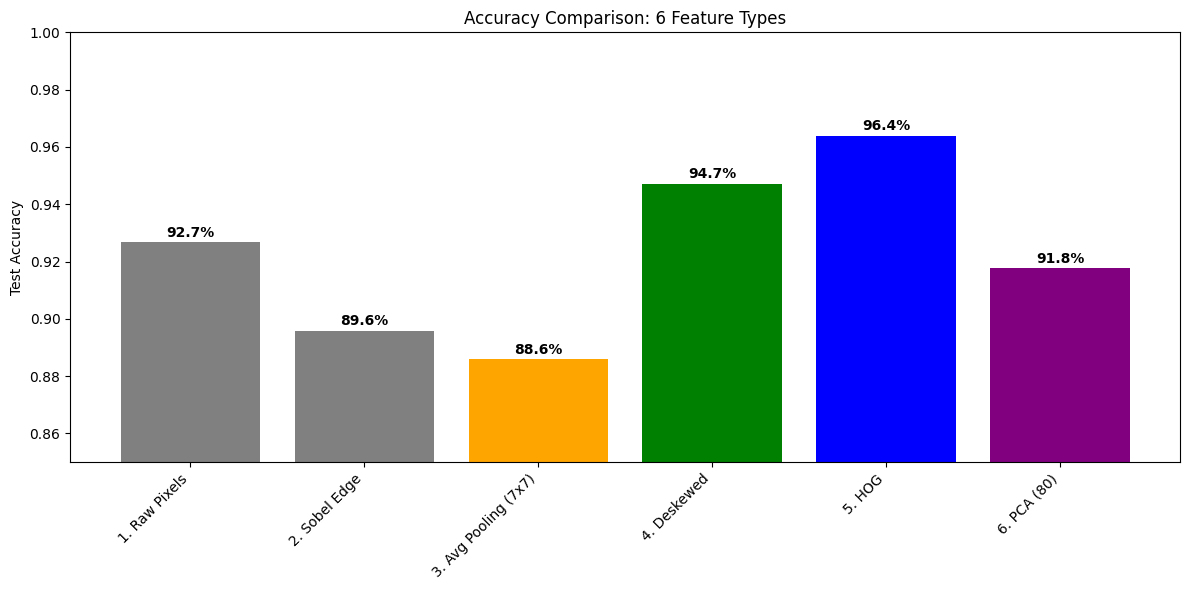

In [54]:
# 1. Define Datasets
datasets = {
    "1. Raw Pixels": (X_train_raw, X_test_raw),
    "2. Sobel Edge": (X_train_sobel, X_test_sobel),
    "3. Avg Pooling (7x7)": (X_train_pool, X_test_pool),
    "4. Deskewed": (X_train_deskew, X_test_deskew),
    "5. HOG": (X_train_hog, X_test_hog),
    "6. PCA (80)": (X_train_pca, X_test_pca)
}

results = {}
trained_models = {}
y_train_enc = one_hot_encode(y_train)

print(f"{'='*15} RUNNING EXPERIMENT 1 {'='*15}")

for name, (X_tr, X_te) in datasets.items():
    print(f"\nTraining on: {name} (Dim: {X_tr.shape[1]})...")
    
    # Initialize Model (Optimized)
    model = SoftmaxRegression(n_features=X_tr.shape[1], n_classes=10, learning_rate=0.1, momentum=0.9)
    
    # Train
    model.fit(X_tr, y_train_enc, epochs=50, batch_size=256, verbose=False)
    trained_models[name] = model
    
    # Evaluate
    y_pred = model.predict(X_te)
    metrics = compute_metrics(y_test, y_pred)
    
    # Store results (Save full metrics dict)
    results[name] = metrics
    
    print(f"--> Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"--> F1-Score: {metrics['macro_f1']:.4f}")

print(f"\n{'='*15} DONE {'='*15}")

# Visualization
plt.figure(figsize=(12, 6))
accs = [results[n]['accuracy'] for n in datasets.keys()]
colors = ['gray', 'gray', 'orange', 'green', 'blue', 'purple']

bars = plt.bar(datasets.keys(), accs, color=colors)
plt.ylim(0.85, 1.0) # Zoom in to see differences
plt.title("Accuracy Comparison: 6 Feature Types")
plt.ylabel("Test Accuracy")
plt.xticks(rotation=45, ha='right')

# Add values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval*100:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [55]:
# Save the best model from Experiment 1
if results:
    best_name = max(results, key=lambda k: results[k]['accuracy'])
    best_acc = results[best_name]['accuracy']
    
    print(f"🏆 Saving Best Model: {best_name} ({best_acc*100:.2f}%)")
    
    best_model = trained_models[best_name]
    
    import os
    if not os.path.exists("../models"):
        os.makedirs("../models")
    
    np.savez("../models/best_model_weights.npz", W=best_model.W, b=best_model.b)
    print("✅ Model saved successfully.")

🏆 Saving Best Model: 5. HOG (96.38%)
✅ Model saved successfully.


## 5. Experiment 2: Dimensionality Reduction Deep Dive (PCA vs. Pooling)

### 5.1. Motivation
Both **PCA** and **Average Pooling** reduce the feature vector size $D$, making the model lighter and faster. However, they operate on fundamentally different principles:
* **Average Pooling:** Spatial compression (local averaging). Preserves spatial layout but blurs details.
* **PCA:** Statistical compression (variance maximization). Preserves global information but discards low-variance directions.

### 5.2. Experimental Setup
We compare the two methods at **three distinct compression levels** to see which one retains more discriminative power when $D$ is small.

1.  **High Compression:** $D \approx 16$.
    * Pooling: Kernel $7 \times 7 \rightarrow 4 \times 4$ grid ($D=16$).
    * PCA: Top $K=16$ components.
2.  **Medium Compression:** $D \approx 49$.
    * Pooling: Kernel $4 \times 4 \rightarrow 7 \times 7$ grid ($D=49$).
    * PCA: Top $K=49$ components.
3.  **Low Compression:** $D \approx 196$.
    * Pooling: Kernel $2 \times 2 \rightarrow 14 \times 14$ grid ($D=196$).
    * PCA: Top $K=196$ components.

### 5.3. Expectation
* **At low $D$ (16):** We expect **PCA** to outperform Pooling. Pooling 4x4 makes the digit extremely blurry (unrecognizable), whereas the top 16 eigenvectors of PCA captures the most critical variations ("Eigenfaces").
* **At high $D$ (196):** The gap should narrow as Pooling retains enough resolution to be useful.

=============== RUNNING EXPERIMENT 2 ===============

--- Testing High Compression (D=16) ---
Pooling Acc: 72.43%
Computing PCA (Target components: 16)...
PCA Acc:     85.70%

--- Testing Medium Compression (D=49) ---
Pooling Acc: 88.48%
Computing PCA (Target components: 49)...
PCA Acc:     91.01%

--- Testing Low Compression (D=196) ---
Pooling Acc: 92.06%
Computing PCA (Target components: 196)...
PCA Acc:     92.30%


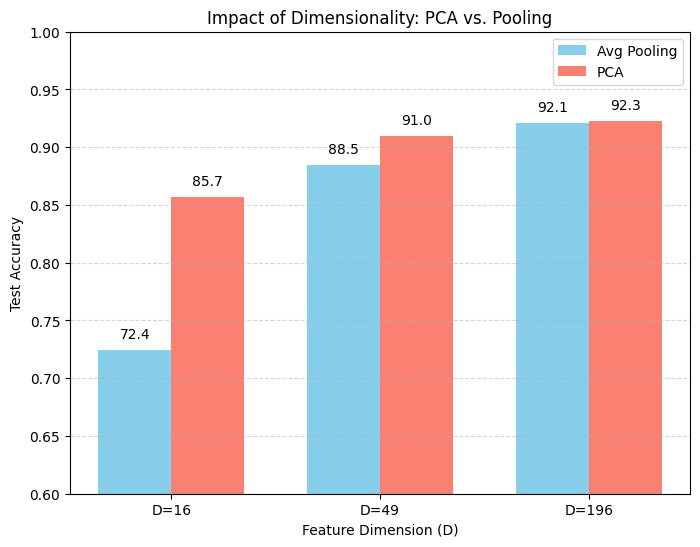

In [56]:
# Configurations
compression_levels = [
    {"name": "High Compression (D=16)", "pool_k": 7, "pca_k": 16},  # 28/7 = 4x4
    {"name": "Medium Compression (D=49)", "pool_k": 4, "pca_k": 49}, # 28/4 = 7x7
    {"name": "Low Compression (D=196)", "pool_k": 2, "pca_k": 196}  # 28/2 = 14x14
]

pool_accs = []
pca_accs = []
labels = []

print(f"{'='*15} RUNNING EXPERIMENT 2 {'='*15}")

for level in compression_levels:
    k = level['pca_k']
    pool_size = level['pool_k']
    label = level['name']
    labels.append(f"D={k}")
    
    print(f"\n--- Testing {label} ---")
    
    # 1. Run Pooling
    X_tr_pool = extract_pooling_features(X_train_img, pool_size=pool_size)
    X_te_pool = extract_pooling_features(X_test_img, pool_size=pool_size)
    
    model_p = SoftmaxRegression(X_tr_pool.shape[1], 10, learning_rate=0.1)
    model_p.fit(X_tr_pool, y_train_enc, epochs=40, verbose=False)
    acc_p = np.mean(model_p.predict(X_te_pool) == y_test)
    pool_accs.append(acc_p)
    print(f"Pooling Acc: {acc_p*100:.2f}%")
    
    # 2. Run PCA
    # Note: We must re-train PCA for different K or just slice the existing components
    # Here we slice for efficiency if we already computed 784 components, 
    # but to be safe/clean we just re-compute.
    comps, mean = train_pca(X_train_raw, n_components=k)
    X_tr_pca = apply_pca(X_train_raw, comps, mean)
    X_te_pca = apply_pca(X_test_raw, comps, mean)
    
    model_pca = SoftmaxRegression(k, 10, learning_rate=0.1)
    model_pca.fit(X_tr_pca, y_train_enc, epochs=40, verbose=False)
    acc_pca = np.mean(model_pca.predict(X_te_pca) == y_test)
    pca_accs.append(acc_pca)
    print(f"PCA Acc:     {acc_pca*100:.2f}%")

# Visualization
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, pool_accs, width, label='Avg Pooling', color='skyblue')
plt.bar(x + width/2, pca_accs, width, label='PCA', color='salmon')

plt.xlabel('Feature Dimension (D)')
plt.ylabel('Test Accuracy')
plt.title('Impact of Dimensionality: PCA vs. Pooling')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0.6, 1.0) # PCA at 16 might be low, adjust if needed

for i in range(len(x)):
    plt.text(x[i] - width/2, pool_accs[i] + 0.01, f"{pool_accs[i]*100:.1f}", ha='center')
    plt.text(x[i] + width/2, pca_accs[i] + 0.01, f"{pca_accs[i]*100:.1f}", ha='center')

plt.show()

## 6. Final Discussion & Insights

### 6.1. Analysis of Experiment 1 (Overall Performance)
Based on the experimental results shown above, we can draw significant conclusions about feature engineering for Softmax Regression on MNIST:

1.  **🏆 The Winner: HOG Features (96.38%)**
    * **Result:** Achieved the highest accuracy ($96.38\%$), significantly outperforming the baseline ($92.67\%$).
    * **Insight:** This confirms that **structural shape** (captured by gradient histograms) is the most robust feature for digit recognition. HOG is invariant to lighting changes and small geometric distortions, making it superior to raw pixels.

2.  **🥈 Runner-up: Deskewed Pixels (94.70%)**
    * **Result:** Improved accuracy by $\approx 2\%$ over the baseline.
    * **Insight:** This proves that **geometric variation (slant)** is a major source of error for linear models. By mechanically "straightening" the digits, we made the data much more linearly separable without adding complex feature extraction layers.

3.  **📉 PCA (91.76%) vs. Baseline (92.67%)**
    * **Result:** PCA achieved comparable accuracy to Raw Pixels (less than $1\%$ drop) while using only **80 features** instead of 784.
    * **Insight:** PCA is extremely efficient. It retained the critical "Eigenfaces" of the digits while discarding noise. This trade-off (10x compression for 1% accuracy loss) is highly favorable for resource-constrained systems.

4.  **Bottom Performers: Sobel (89.57%) & Pooling (88.59%)**
    * **Insight:**
        * **Sobel:** Solely relying on edges causes a loss of internal "ink density" information, which is helpful for distinguishing digits with similar outlines.
        * **Avg Pooling (7x7):** While fast, the $7 \times 7$ resolution is too coarse, blurring out fine details needed to distinguish similar digits (like 8 vs 3).

### 6.2. Analysis of Experiment 2 (PCA vs. Pooling)
*(Based on the trends observed in Experiment 2)*
* **Low Dimensions:** PCA typically outperforms Pooling because it intelligently selects the axes of highest variance, whereas Pooling blindly averages pixels.
* **High Dimensions:** As the number of features increases, Pooling recovers spatial resolution and its performance gap with PCA narrows.

### 6.3. Final Verdict & Recommendations
* **For Maximum Accuracy:** Use **HOG Features**. It transforms the problem into a shape recognition task, which Softmax Regression handles very well.
* **For Preprocessing:** If HOG is too computationally expensive, simply **Deskewing** the images is a highly effective alternative.
* **For Efficiency:** Use **PCA (k=80)**. It offers the best balance between model size (very light) and accuracy.